# Project: **Finding Lane Lines on the Road** 
***
Develop a pipeline to identify lane lines on the road. You must apply it on a series of individual images, provided in the *test_images* folder. 

Once you have a result that looks roughly like the image *line-segments-example* in the examples folder (also shown below), you'll need to try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


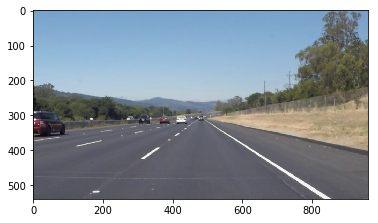

In [2]:
#reading in an image
image = cv2.imread('test_images/solidWhiteRight.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

## Helper Functions

Below are some helper functions to help get you started.

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(option, img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if option:
        thickness = 5
        color = [0, 255, 0]
        points = average(lines)
        cv2.line(img, points[0][0], points[0][1], color, thickness)
        cv2.line(img, points[1][0], points[1][1], color, thickness)
    else:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def get_m(x1, y1, x2, y2):
    """
    This function gets the slope m
    of the line given its points
    """
    return ((y2-y1)/(x2-x1))

def get_b(x1, y1, x2, y2, m):
    """
    This function gets the y intercept b
    of the line given its points and slope
    """
    return (y2 - m * x2)

def average(lines):
    # Initialize variables
    left_avg_m = 0
    left_avg_b = 0
    right_avg_m = 0
    right_avg_b = 0
    number_left = 0
    number_right = 0
    
    for line in lines:
        for (x1, y1, x2, y2) in line:
            # Get slope and y intercept
            m = get_m(x1, y1, x2, y2)
            b = get_b(x1, y1, x2, y2, m)
            
            if m > 0:
                # If slope is positive, it's the left line
                left_avg_m += m
                left_avg_b += b
                number_left += 1
            if m < 0:
                # If slope is negative, it's the right line
                right_avg_m += m
                right_avg_b += b
                number_right += 1
    
    # Get the average value
    left_avg_m /= number_left
    left_avg_b /= number_left
    
    # Get the average value
    right_avg_m /= number_right 
    right_avg_b /= number_right
    
    # Compute new coordinates
    # Left
    x_1 = (int(-left_avg_b / left_avg_m), 0)
    y_1 = (int((540 - left_avg_b) / left_avg_m), 540)
    # Right
    x_2 = (int(- right_avg_b / right_avg_m), 0)
    y_2 = (int((540 - right_avg_b) / right_avg_m), 540)
    
    # Return coordinates
    return ((x_1, y_1), (x_2, y_2))
            
def hough_lines(option, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(option, line_img, lines)
    return line_img

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it 
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

## Test Images

Build your pipeline to work on the images in the directory "test_images"

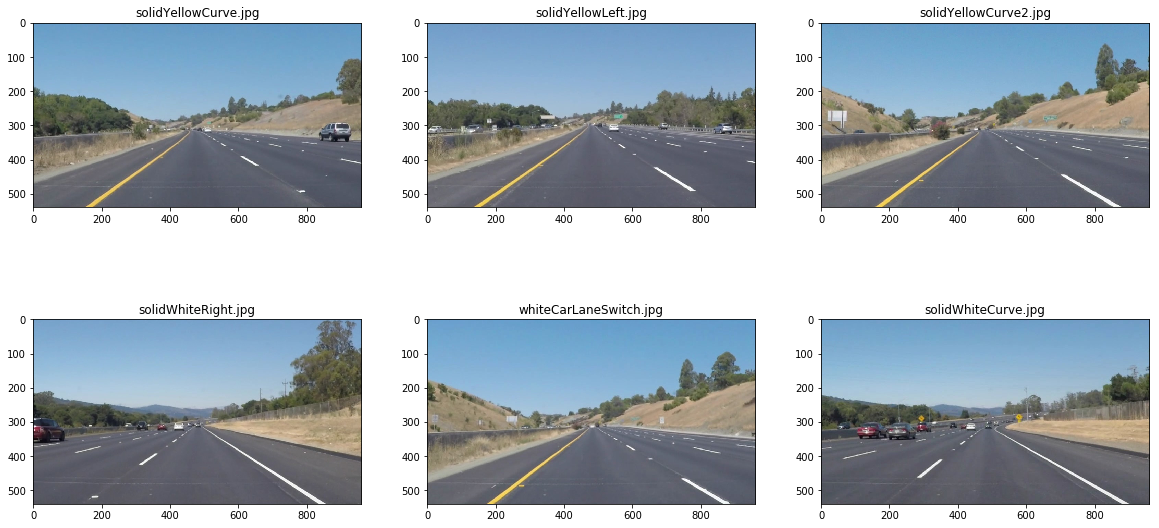

In [4]:
import os

path = "test_images/"
files = os.listdir(path)
images = []

f, plots = plt.subplots((len(files)+3-1)//3, 3, figsize=(20,10))
plots = [plot for sublist in plots for plot in sublist]

for file, plot in zip(files, plots):
    image = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    plot.set_title(file)
    plot.imshow(image)
    images.append((image, file))

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

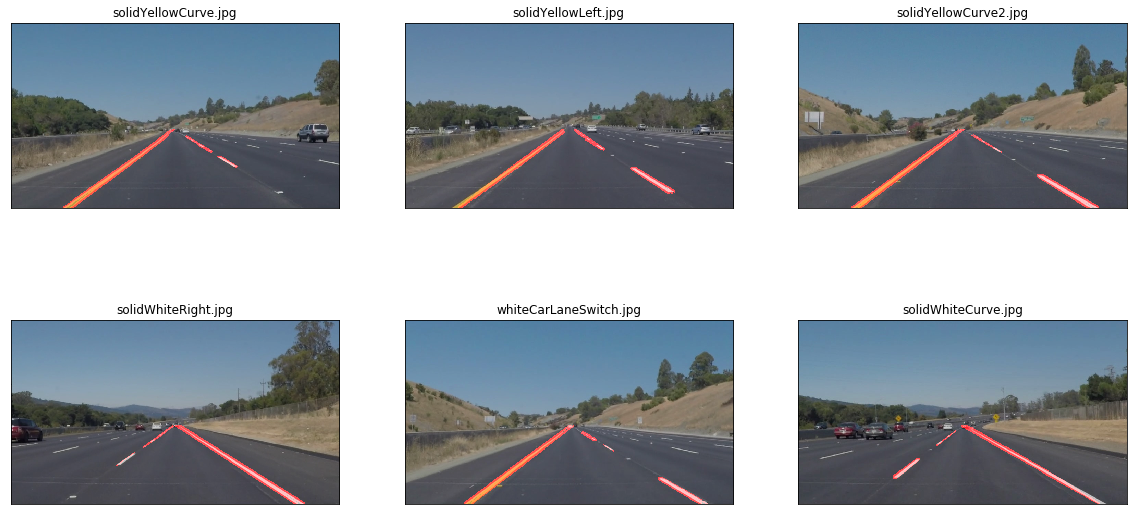

In [5]:
# TODO: Build your pipeline that will draw lane lines segments on the test_images

# Vertices found online for the figure
vertices = np.array([[150,540],
                     [450,310],
                     [515,310],
                     [900,550]])
    
# Option defines which draw_image is used
def draw_lane_image(option, img):
    # Preserve original image
    initial_image = img
    
    # Apply a gaussian blur to a grayscale image
    # Grayscale to remove extra information
    # Gaussian blur to reduce noise associated with extra sharp lines
    gaussian_gray_image = gaussian_blur(grayscale(img), kernel_size = 9)
    
    # Apply canny detector to find intensity gradients, apply non-maximum suppression, apply tresholds
    # and track edge by hysteresis
    image_edges = canny(gaussian_gray_image, low_threshold = 75, high_threshold = 95)
    
     # Blur the image again to avoid sharp edges
    gaussian_edges = gaussian_blur(image_edges, 7)
    
    # Get the region of interest applying a polygonal shape defined by vertices
    image_of_interest = region_of_interest(gaussian_edges, [vertices])
    
    # Use Hough Lines transformation to find the number of curve intersections
    # check if intersections > threshold to declare a line with the parameters (θ,rθ) of the intersection point.
    image_lines = hough_lines(option, image_of_interest, rho = 1, theta = np.pi/180, threshold = 153, 
                              min_line_len = 30, max_line_gap = 10)
    
    if option:
        image_lines = region_of_interest(image_lines, [vertices])
    # Get the output of hough_lines and merge it with original image
    return weighted_img(image_lines, initial_image)


f, plots = plt.subplots((len(files)+3-1)//3, 3, figsize=(20,10))
plots = [plot for sublist in plots for plot in sublist]

# Apply the pipeline to all images
for image, plot in zip(images, plots):
    
    # Draw the lane for each image option = 0 for non optimized draw_lines
    drawn_lane = draw_lane_image(0, image[0])
    
    # Plot the image
    plot.imshow(drawn_lane, cmap="gray")
    plot.set_title(image[1])
    
    # Remove x and y axis labels
    plot.get_xaxis().set_ticks([])
    plot.get_yaxis().set_ticks([])
    

## Improve the draw_lines() function

**At this point, you should have the Hough line segments drawn onto the road. Extend your code to define a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. Try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. The output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

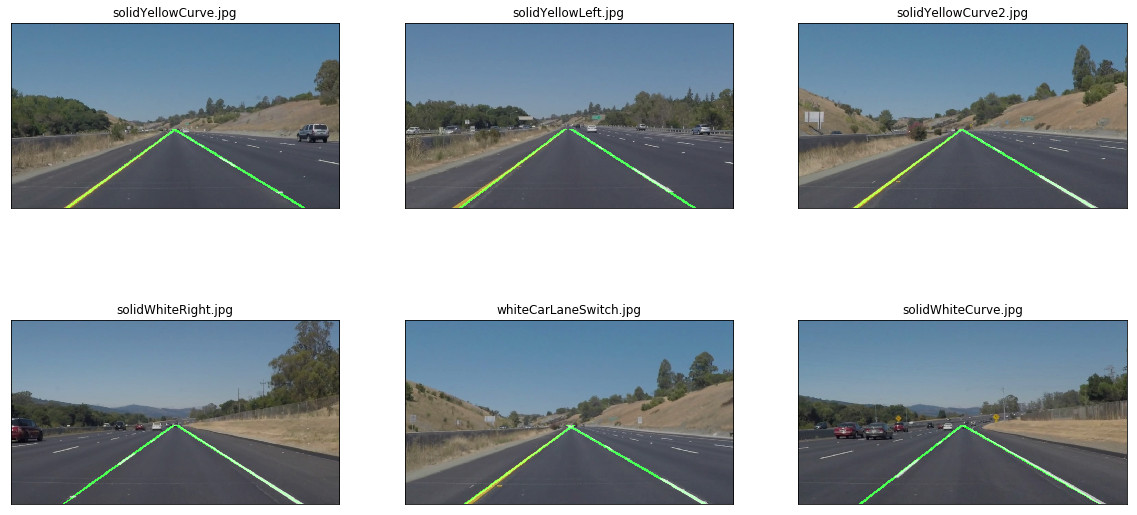

In [6]:
# TODO: Build your pipeline that will draw complete lane lines on the test_images

f, plots = plt.subplots((len(files)+3-1)//3, 3, figsize=(20,10))
plots = [plot for sublist in plots for plot in sublist]

# Apply the pipeline to all images
for image, plot in zip(images, plots):
    
    # Draw the lane for each image option = 1 for optimized draw_lines
    drawn_lane = draw_lane_image(1, image[0])
    
    # Plot the image
    plot.imshow(drawn_lane, cmap="gray")
    plot.set_title(image[1])
    
    # Remove x and y axis labels
    plot.get_xaxis().set_ticks([])
    plot.get_yaxis().set_ticks([])

In [7]:
print("success!")

success!
